In [185]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from cbook2 import nice_clevels, nice_mxmnintvl

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70]

tclevs = list(-15.0 + np.arange(31))

plevs = list(-15.0 + np.arange(31))

dlevs = list(-15.0 + np.arange(31))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scipy.stats import gaussian_kde

def kde_plotter(mdata, mlabel, mcolor, ax=None):

    xlim = [-15,55]
    
    if ax == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))

    for data, label, color in zip(mdata,mlabel,mcolor):
        # print(label, color)
        
        hist, bin_edges = np.histogram(data.flatten())

        data_no_zero = data.flatten()
    
        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.9)
        y_sp        = kde_sp.pdf(eval_points)
        
        ax.plot(eval_points, y_sp, color=color, linewidth=2.0, label='%s  %d' % (label,data_no_zero.shape[0]))
             
    ax.set_xlim(xlim[:])
    ax.set_yscale("log")
#    ax.set_xscale("log", base=2.0)
    plt.grid(axis='y', alpha=0.75)
    plt.grid(axis='x', alpha=0.75)
    ax.set_xlabel('W (m/s)',fontsize=15)
    ax.set_ylabel('Density',fontsize=15)
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
    ax.axvline(x=80.0, color='k', linestyle='--', linewidth=2.0)
    ax.set_title('W' , fontsize=15)

In [187]:
#---------------------------------------------------------------------
# local interp function
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):

    # dinterp = np.zeros((len(z1d),),dtype=np.float32)

    # # for j in np.arange(data.shape[1]):
    # dinterp[:] = np.interp1d(z1d, z3d[:], data[:])

    f_linear = scipy.interpolate.interp1d(z3d,data) 

    return f_linear(z1d)

def container(*field):

    import xarray as xr

    if len(field) == 1:
        x = np.arange(field[0].shape[1])
        y = np.arange(field[0].shape[0])

        return xr.DataArray( field[0], dims=("ny", "nx"), coords={"X": (["nx"], x), 
                                                                  "Y": (["ny"], y)} )
    elif len(field) == 3:

        return xr.DataArray(field[2], dims=("ny", "nx"), coords={"X": (["ny", "nx"], field[0].data), 
                                                                 "Y": (["ny", "nx"], field[1].data)} )
    
def plot_contour_row(fields, levels=None, transpose=False, extra_levels=None, range=None, 
                     title='', var='', xlabel='x', ylabel='y',  cmap='RdBu_r'):

    if len(fields) == 1:
         fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(10,10))
         axes = [ax,]
    else:
        fig, axes = plt.subplots(1,len(fields), constrained_layout=True, figsize=(5*len(fields),5))

    for ax, field in zip(axes, fields):

        fld = field.values
        x   = field.X.values
        y   = field.Y.values
        
        if not levels:
            amin, amax, levels = nice_clevels(fld.min(), fld.max())
                 
        if transpose:
            
            if x.dim > 1:  
                x = x.transpose()
            else:
                xx = x
                x  = y
                
            if y.dim > 1:  
                y = y.transpose()
            else:
                y = xx
            
            a = ax.contourf(x, y, fld.transpose(), levels=levels, cmap=cmap)
            ax = ax.contour(x, y, fld.transpose(), levels = extra_levels, colors='k', alpha=0.5)

        else:
            
            a = ax.contourf(x, y, fld, levels=levels, cmap=cmap)
            ax.contour(x, y, fld, levels = extra_levels, colors='k', alpha=0.5)
        
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        
        ax.set_title("%s: %s  Max: %6.2f  Min: %6.2f" % (title, var, field.max(), field.min()), fontsize=10)

        if range:
            ax.set_xlim(range)

    # fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([1.,0.175, 0.03, 0.7])
    fig.colorbar(a, cax=cbar_ax)

    return fig, axes

def plot_w_xz(x, z, w, ax=None, title='Model', range=None, varlab='W', levels=clevs, transpose=False):

    zhgts = (100. + 100.*np.arange(200))/1000.
    
    if ax == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))

    # winterp = np.zeros((x.shape[0],len(zhgts)),dtype=np.float32)
    
    # for n in np.arange(x.shape[0]):
    #     winterp[ = interp3dz_np(w[:,n], z[:,n], zhgts, nthreads = -2)

    # if transpose:
    #     ax.contourf(x, zhgts, winterp.transpose(), clevs, cmap=plt.cm.viridis_r)
    #     ax.contour(x, zhgts, winterp.transpose(), [5,15,25,35,45], colors='k', alpha=0.5)
    #     ax.contour(x, zhgts, winterp.transpose(), [-10,-5], colors='b', alpha=0.5)
    # else:
    
    ax.contourf(x, z, w, levels, cmap=plt.cm.viridis_r)
    ax.contour (x, z, w, [5,15,25,35,45], colors='k', alpha=0.5)
    ax.contour (x, z, w, [-10,-5], colors='b', alpha=0.5)
    ax.contour (x, z, w, [1,], colors='k', linethickness=2.0)
    
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_ylabel('Z (km)', fontsize=12)

    ax.axhline(y=10.)

    if range:
        ax.set_xlim(range)
    
    ax.set_title("%s: XZ for %s  Max: %6.2f  Min: %6.2f" % (title, varlab, w.max(), w.min()), fontsize=12)

def plot_theta_xz(x, z, th, ax=None, title='Model', varlab='Pert-TH', range=None, levels=tclevs, transpose=False):

    zhgts = (100. + 100.*np.arange(200))/1000.
    
    if ax == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))

    # winterp = np.zeros((x.shape[0],len(zhgts)),dtype=np.float32)
    
    # for n in np.arange(x.shape[0]):
    #     winterp[ = interp3dz_np(w[:,n], z[:,n], zhgts, nthreads = -2)

    # if transpose:
    #     ax.contourf(x, zhgts, winterp.transpose(), clevs, cmap=plt.cm.viridis_r)
    #     ax.contour(x, zhgts, winterp.transpose(), [5,15,25,35,45], colors='k', alpha=0.5)
    #     ax.contour(x, zhgts, winterp.transpose(), [-10,-5], colors='b', alpha=0.5)
    # else:
    
    ax.contourf(x, z, th, levels, cmap=plt.cm.viridis_r)
    ax.contour (x, z, th, [5,7], colors='r', alpha=0.5)
    ax.contour (x, z, th, [1,], colors='k', linethickness=2.0)
    
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_ylabel('Z (km)', fontsize=12)

    ax.axhline(y=10.)

    if range:
        ax.set_xlim(range)
    
    ax.set_title("%s: XZ for %s  Max: %6.2f  Min: %6.2f" % (title, varlab, th.max(), th.min()), fontsize=12)


### SOLO

In [6]:
paths = {}
paths['solo_3km_hdd125'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00'
paths['solo_2km_hdd125'] = '/work/wicker/Odin_scr/solo/bubble_2km_dt12_hdd125_C2000_00'
paths['solo_1km_hdd125'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt06_hdd125_C2000_00'

solo_hdd125 = [read_solo_fields(paths['solo_3km_hdd125'], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
               read_solo_fields(paths['solo_2km_hdd125'], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
               read_solo_fields(paths['solo_1km_hdd125'], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=True)]


------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc 

 -->Computing finite difference 2D divergence

 Completed reading in:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_2km_dt12_hdd125_C2000_00/atmos_hifreq.nc
--------------------------------------------

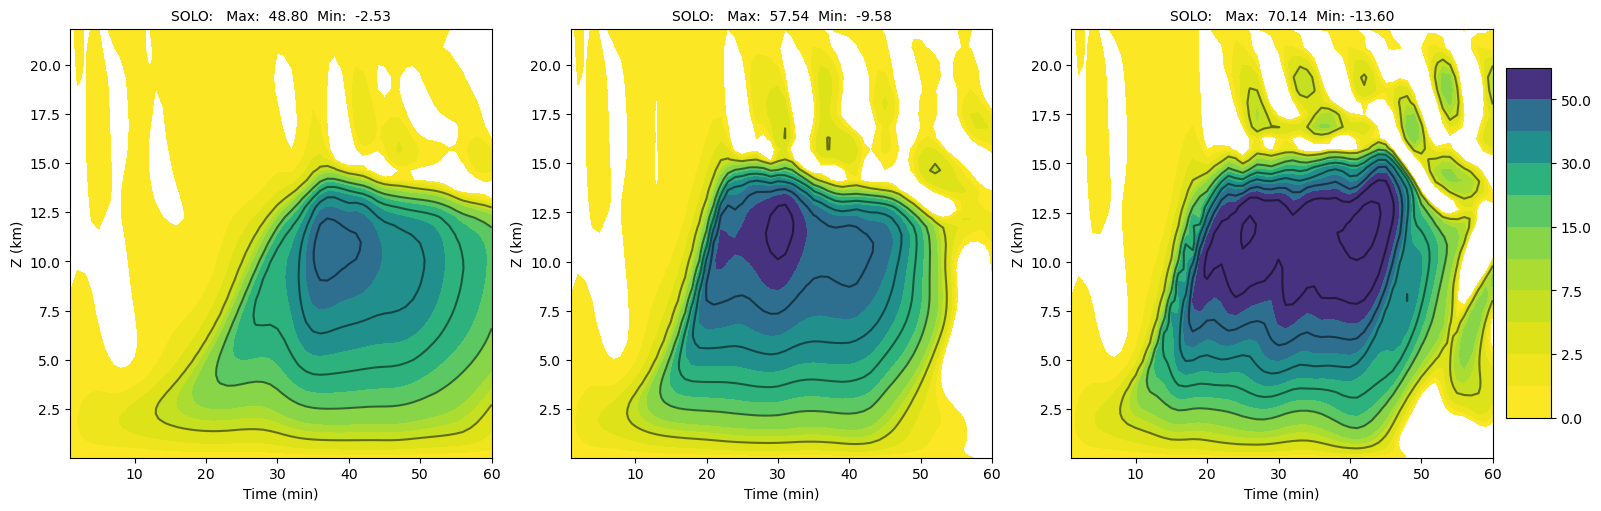

In [177]:


#
time1 = solo_hdd125[0][1]['time']/60.
time  = np.tile(time1, (60,1)).transpose()

#

fields = []

for n in np.arange(3):

    if n == 0:
        iloc, jloc = 32, 32
    elif n == 1:
        iloc, jloc = 48, 48
    else:
        iloc, jloc = 96, 96

    w_col = solo_hdd125[n][0]['w'][:,:,jloc, iloc]
    z_col = solo_hdd125[n][0]['hgt'][:,:,jloc, iloc] * 0.001

    fields.append(container(time, z_col, w_col))

plot_contour_row(fields, levels=wclevs, title='SOLO', xlabel='Time (min)', ylabel='Z (km)', extra_levels=[5,15,25,35,45,55,65], cmap=plt.cm.viridis_r);


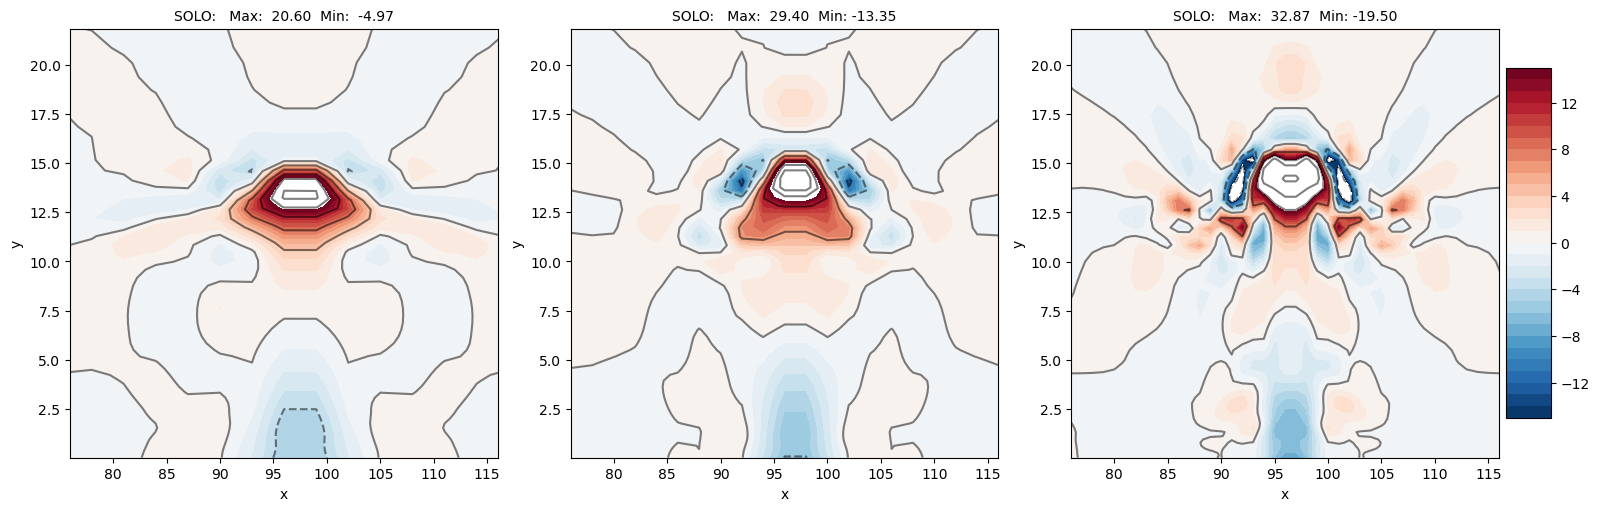

In [189]:
# Divergence

loc = [[40, 32], [30, 48], [25, 96]]

fields = []

for n in np.arange(3):

    tloc, jloc = loc[n][:]

    if n == 0:
        dx = 3.
        
    elif n == 1:
        dx = 2.
        
    else:
        dx = 1.0

    z_col = solo_hdd125[n][0]['hgt'][tloc,:,jloc, :] * 0.001

    x1 = solo_hdd125[n][1]['grid_xt'].values*dx

    x  = np.tile(x1, (z_col.shape[0],1))

    d = solo_hdd125[n][0]['div2d'][tloc,:,jloc,:] / dx
        
    fields.append(container(x, z_col,d))
    
# Compare exact and calculated derivative:

plot_contour_row(fields, levels=dlevs, title='SOLO', range=[76,116]);


### CM1 - 3km

In [24]:
paths = {}
paths['cm1_3km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00'
paths['cm1_2km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_2km_dt03_hdd125_C2000_00'
paths['cm1_1km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt01_hdd125_C2000_00'

cm1_hdd125 = [read_cm1_fields(paths['cm1_3km_hdd125'] , vars = ['+','div2d','uns_div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
              read_cm1_fields(paths['cm1_2km_hdd125'] , vars = ['+','div2d','uns_div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
              read_cm1_fields(paths['cm1_1km_hdd125'] , vars = ['+','div2d','uns_div2d'], file_pattern=None, ret_dbz=False, ret_ds=True)]

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc 

 -->Computing unstaggered finite difference 2D divergence

 -->Computing finite difference 2D divergence

 Completed reading in:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_2km_dt03_hdd

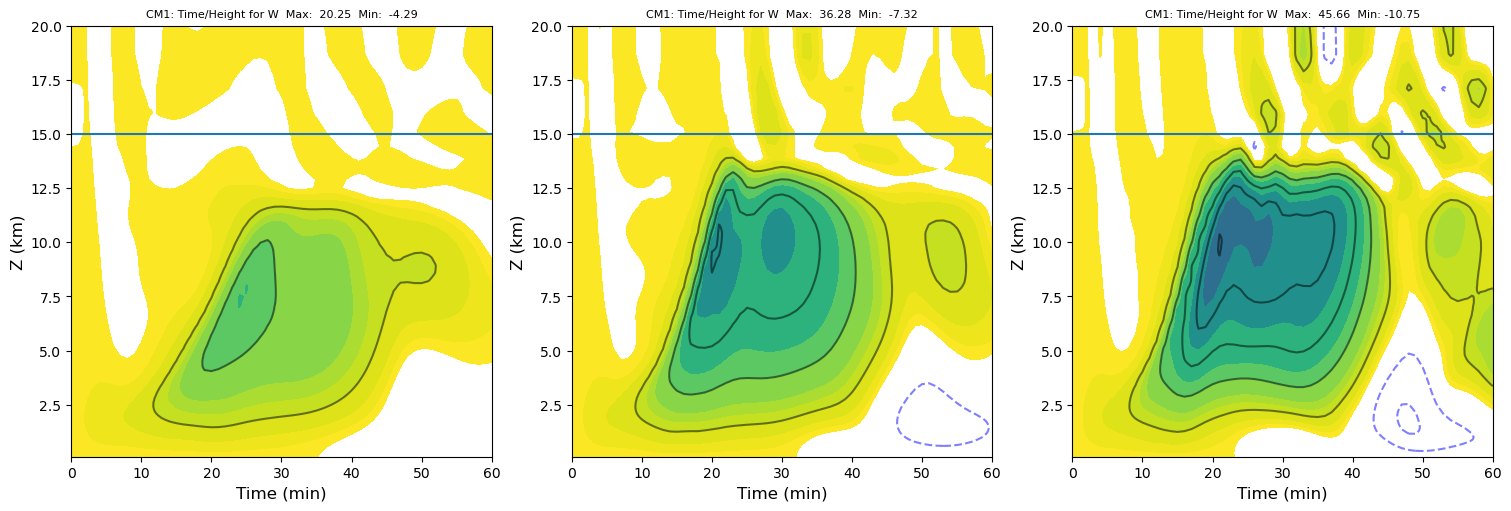

In [9]:
# CM1 multi-resolution plots

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

#
time1 = cm1_hdd125[0][1]['time']/60.
time  = np.tile(time1, (60,1)).transpose()

for n in np.arange(3):

    if n == 0:
        iloc, jloc = 32, 32
    elif n == 1:
        iloc, jloc = 48, 48
    else:
        iloc, jloc = 96, 96
        
    z1d    = cm1_hdd125[n][1].zh.values[:]
    z_col  = np.tile(z1d, (time1.shape[0],1))

    w_col = cm1_hdd125[n][0]['w'][:,:,jloc, iloc]

    plot_w_time_height(time1, z_col, w_col, ax=ax[n], title='CM1')


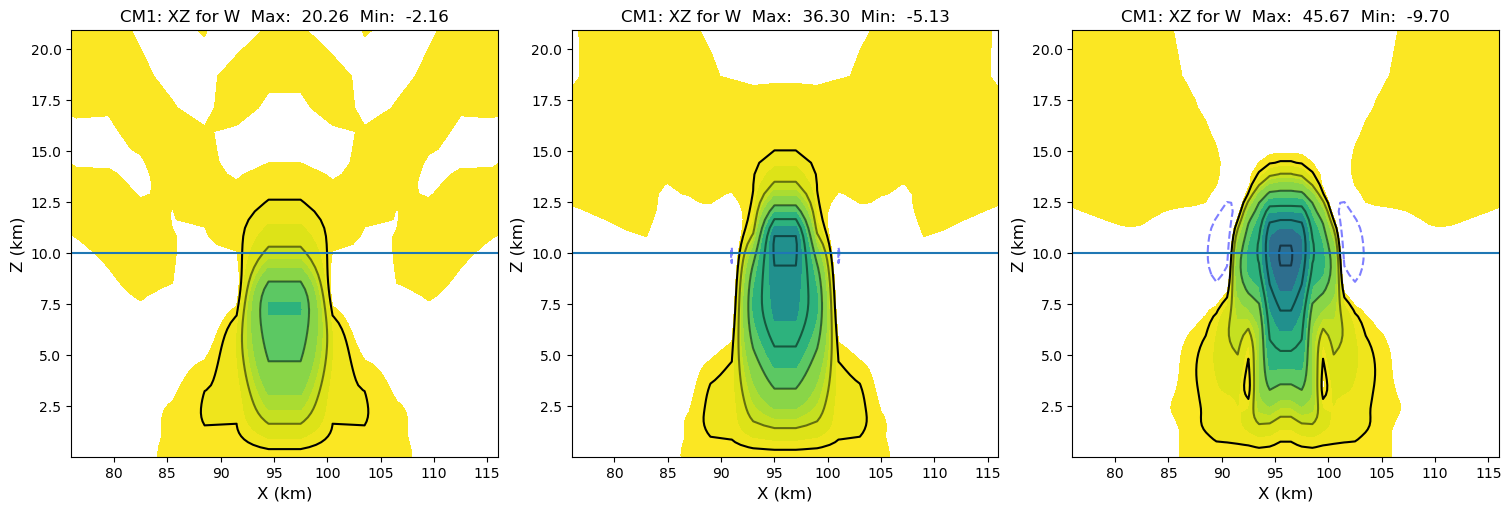

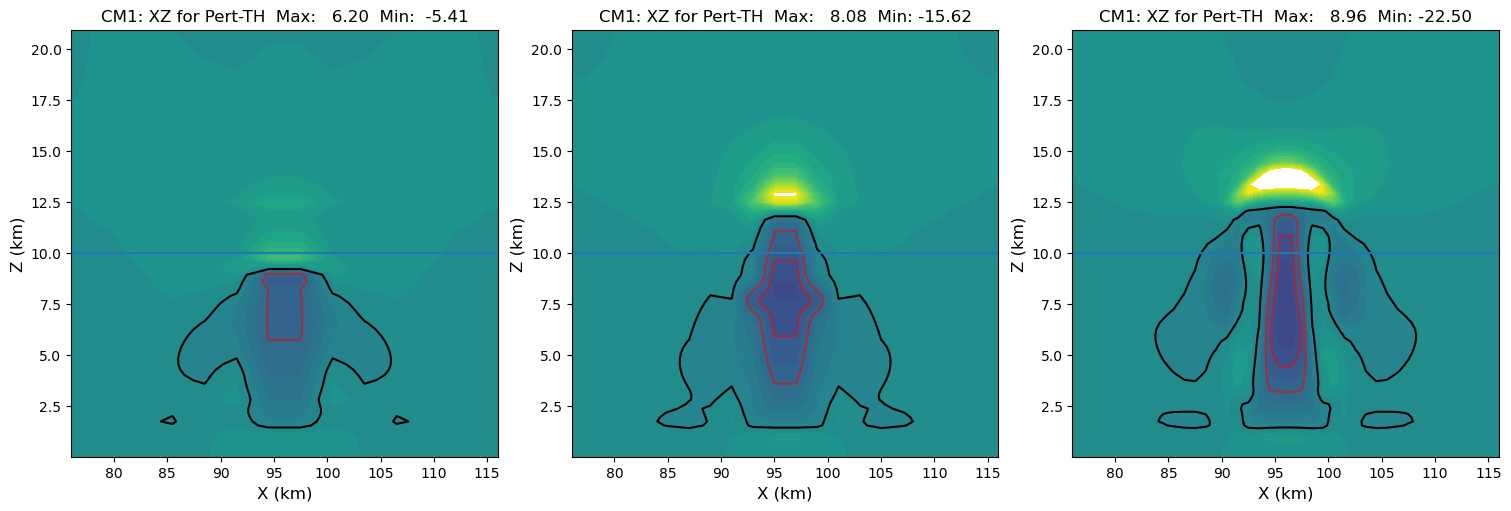

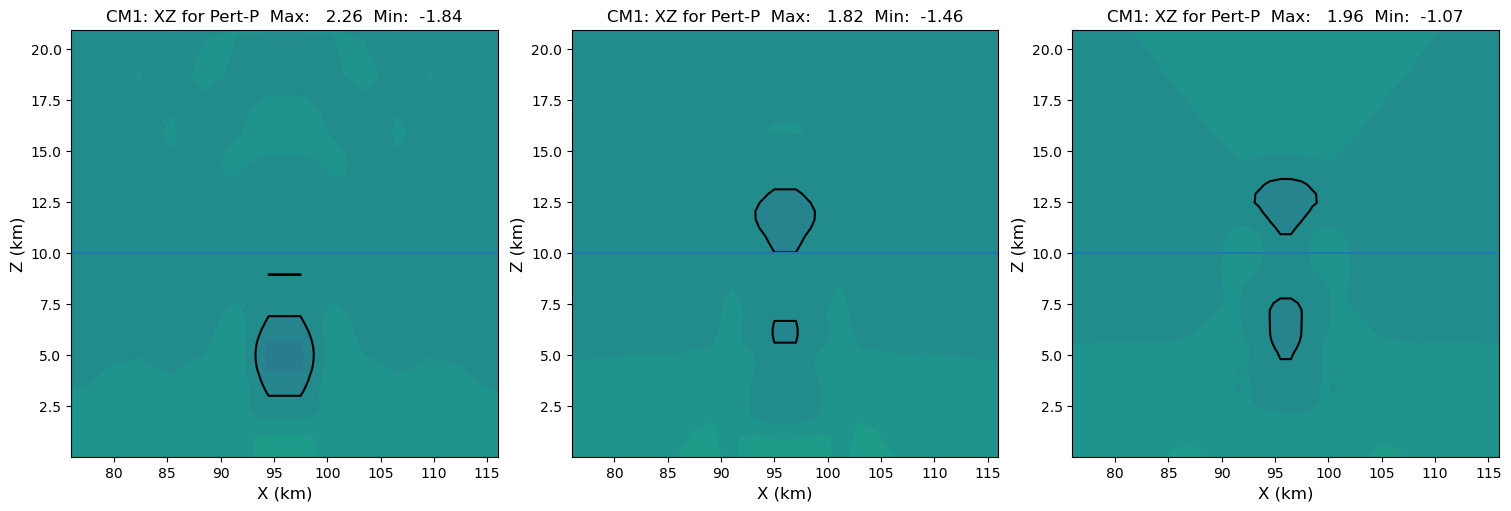

In [10]:
# CM1 plots

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

for n in np.arange(3):

    time1 = cm1_hdd125[n][1]['time']/60.
    time  = np.tile(time1, (60,1)).transpose()

    if n == 0:
        
        tloc, jloc = 24, 32  

    elif n == 1:
        
        tloc, jloc = 21, 48
                
    else:
        
        tloc, jloc = 21, 96

    z2d   = cm1_hdd125[n][0]['hgt'][tloc,:,jloc, :]*0.001
    x1  = cm1_hdd125[n][1]['xh']
    x   = np.tile(x1, (z2d.shape[0],1))

    w_col = cm1_hdd125[n][0]['w'][tloc,:,jloc, :]

    plot_w_xz(x.transpose(), z2d.transpose(), w_col.transpose(), ax=ax[n], title='CM1', range=[76,116])

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

for n in np.arange(3):

    time1 = cm1_hdd125[n][1]['time']/60.
    time  = np.tile(time1, (60,1)).transpose()

    if n == 0:
        
        tloc, jloc = 24, 32  

    elif n == 1:
        
        tloc, jloc = 21, 48
                
    else:
        
        tloc, jloc = 21, 96
        
    z2d = cm1_hdd125[n][0]['hgt'][tloc,:,jloc, :]*0.001
    x1  = cm1_hdd125[n][1]['xh']
    x   = np.tile(x1, (z2d.shape[0],1))
    th_col = cm1_hdd125[n][0]['pert_th'][tloc,:,jloc, :]

    plot_theta_xz(x.transpose(), z2d.transpose(), th_col.transpose(), ax=ax[n], title='CM1', range=[76,116])

# pert pressure

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

for n in np.arange(3):

    time1 = cm1_hdd125[n][1]['time']/60.
    time  = np.tile(time1, (60,1)).transpose()

    if n == 0:
        
        tloc, jloc = 24, 32  

    elif n == 1:
        
        tloc, jloc = 21, 48
                
    else:
        
        tloc, jloc = 21, 96

    z2d   = cm1_hdd125[n][0]['hgt'][tloc,:,jloc, :]*0.001
    x1  = cm1_hdd125[n][1]['xh']
    x   = np.tile(x1, (z2d.shape[0],1))

    w_col = cm1_hdd125[n][0]['pert_p'][tloc,:,jloc, :]/100.

    plot_w_xz(x.transpose(), z2d.transpose(), w_col.transpose(), varlab='Pert-P', levels=plevs, ax=ax[n], title='CM1', range=[76,116])





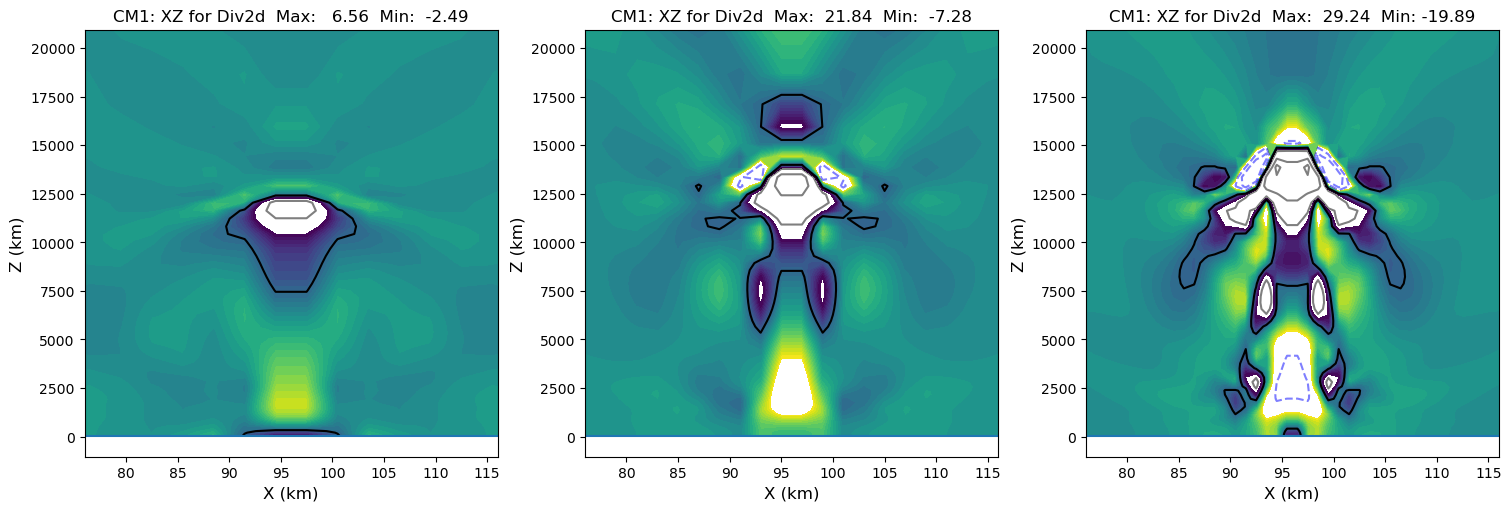

In [27]:
# Divergence

from numpy.fft import fftn, ifftn, fftfreq

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

loc = [[40, 32], [30, 48], [25, 96]]

def freq_axis(x):
    """Calculate the k_j values"""
    N = len(x)
    k_max = N // 2
    if N % 2 == 0:
        k = [k_ for k_ in range(k_max)] + [k_ for k_ in range(-k_max, 0)]
    else:
        k = [k_ for k_ in range(k_max+1)] + [k_ for k_ in range(-k_max, 0)]    
    return np.array(k) * 2*np.pi / (x[-1] - x[0])

for n in np.arange(3):

    time1 = cm1_hdd125[n][1]['time']/60.
    time  = np.tile(time1, (60,1)).transpose()

    tloc, jloc = loc[n][:]

    z2d = cm1_hdd125[n][0]['hgt'][tloc,:,jloc, :]
    N   = z2d.shape[1]-1
    x1  = cm1_hdd125[n][1]['xh'][:-1].values
    y1  = cm1_hdd125[n][1]['yh'][:-1].values

    x   = np.tile(x1, (z2d.shape[0],1))
    
# Multiply and do back transformation:
    
    d = cm1_hdd125[n][0]['div2d'][tloc,:,jloc,:]
    
# Compare exact and calculated derivative:
    plot_w_xz(x.transpose(), z2d.transpose()[:-1], d.transpose()[:-1], varlab='Div2d', levels=dlevs, ax=ax[n], title='CM1', range=[76,116])


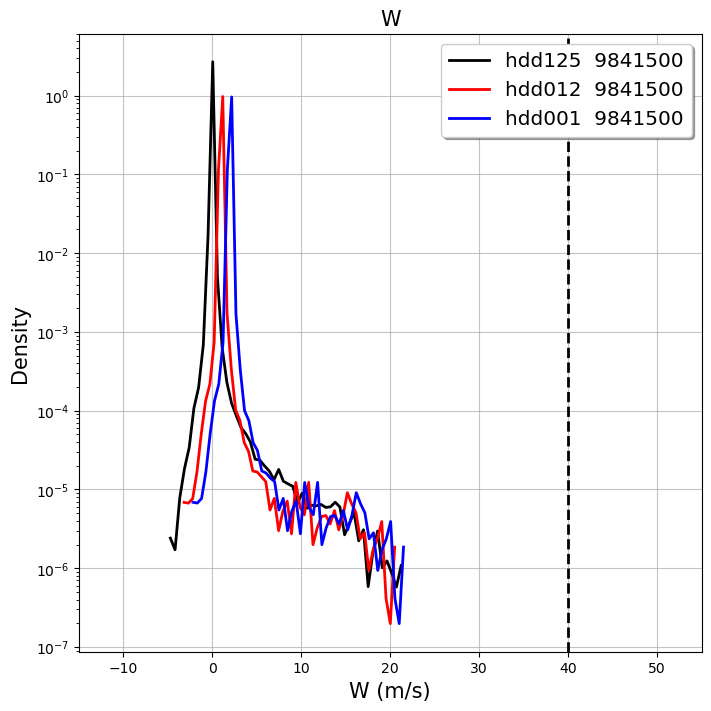

In [99]:
kde_plotter([cm1_hdd125[0][0]['w'],cm1_hdd125[1][0]['w']+1,cm1_hdd125[2][0]['w']+2], ['hdd125','hdd012','hdd001'], ['k','r','b'])
plt.show()

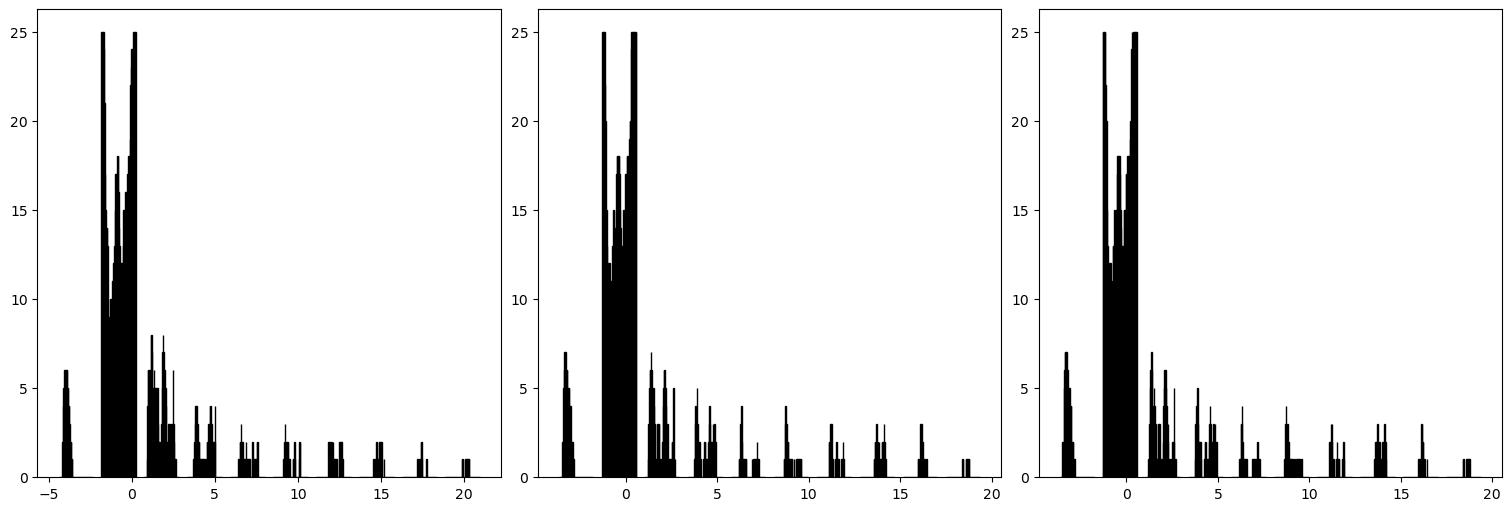

In [38]:
fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))
ax[0].hist(w_col, bins=10, edgecolor='black')
ax[1].hist(w_col2, bins=10, edgecolor='black')
ax[2].hist(w_col3, bins=10, edgecolor='black')
plt.show()

### CM1 - 1 km

In [79]:
paths = {}
paths['cm1_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd125_C2000_00'
paths['cm1_hdd012'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd012_C2000_00'
paths['cm1_hdd001'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd001_C2000_00'

cm1_1km = [read_cm1_fields(paths['cm1_hdd125'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True),
           read_cm1_fields(paths['cm1_hdd012'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True),
           read_cm1_fields(paths['cm1_hdd001'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True)]

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd125_C2000_00/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd125_C2000_00/cm1out.nc 

 Completed reading in:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd125_C2000_00/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt05_hdd012_C2000_00/cm1out.nc
-----------------------------------------------------------------------------------

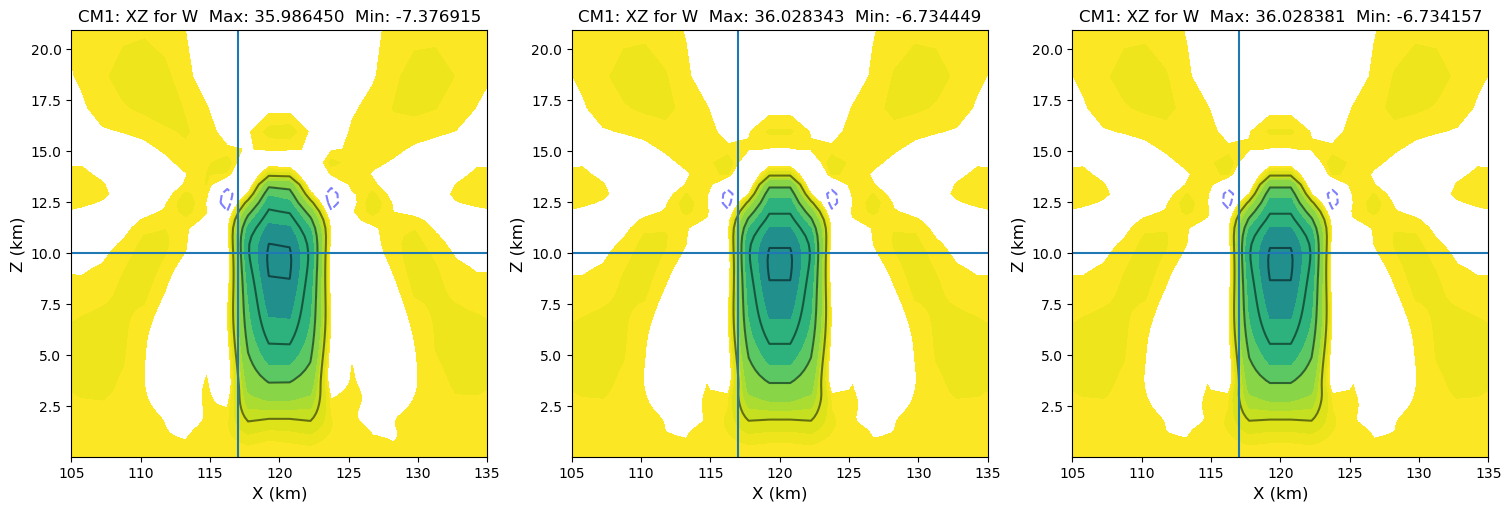

In [83]:
# CM1 plots

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

tloc, jloc = 6, 80

#

z2d = cm1_1km[0][0]['hgt'][tloc,:,jloc, :]*0.001

#
x1  = cm1_1km[0][1]['xh']
x   = np.tile(x1, (z2d.shape[0],1))
for n in np.arange(3):

    w_col = cm1_1km[n][0]['w'][tloc,:,jloc, :]
    plot_w_xz(x.transpose(), z2d.transpose(), w_col.transpose(), ax=ax[n], title='CM1', range=[105,135])
    ax[n].axvline(x=117)

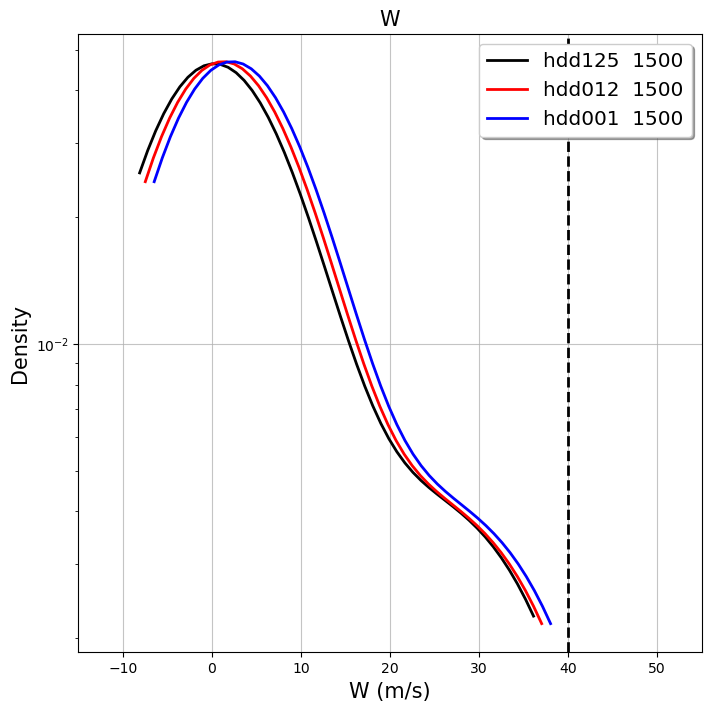

In [56]:
kde_plotter([w_col,w_col2+1.0,w_col3+2.0], ['hdd125','hdd012','hdd001'], ['k','r','b'])
    
plt.show()

In [75]:
paths = {}
paths['solo_hdd125'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00'
paths['solo_hdd012'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd012_C2000_00'
paths['solo_hdd001'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd001_C2000_00'

solo_1km = [read_solo_fields(paths['solo_hdd125'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True),
            read_solo_fields(paths['solo_hdd012'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True),
            read_solo_fields(paths['solo_hdd001'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True)]

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd012_C2000_00/atmos_hifreq.nc
-------------------------------------------------------------------------------------------

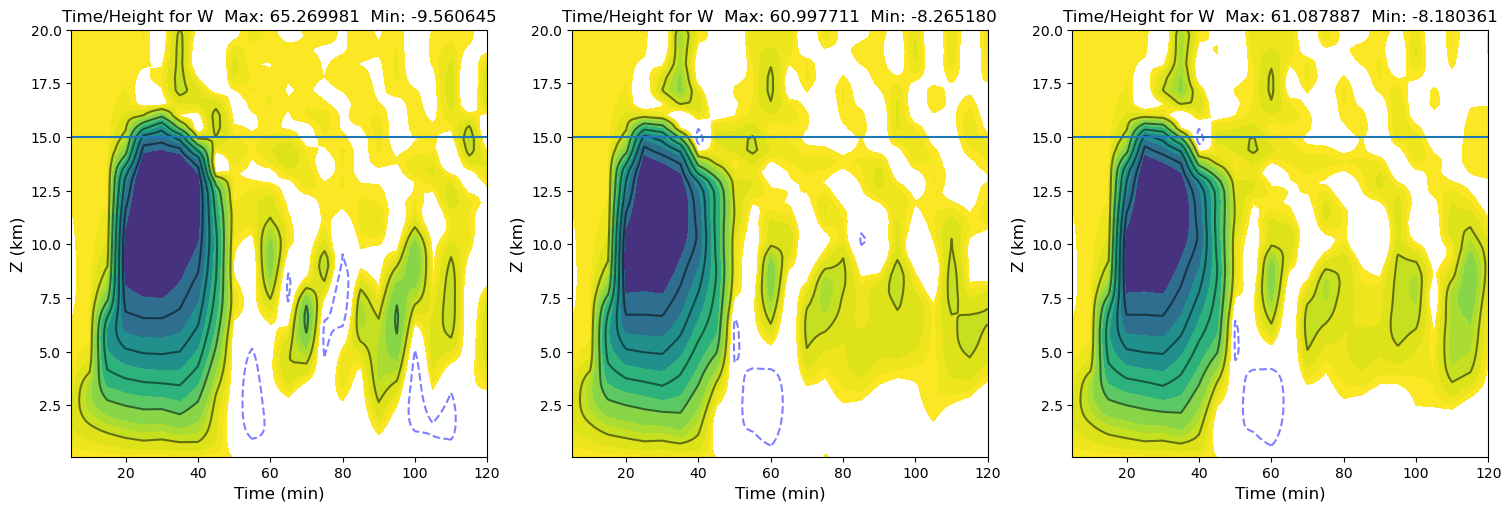

In [14]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70]

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

iloc, jloc = 80,80

#
time1 = dims['time']/60.
time = np.tile(time1, (60,1)).transpose()

#

z3d    = dims.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)

w_col = ds['w'][:,:,jloc, iloc]
z_col = z3d[:,:,jloc, iloc] * 0.001
wplot(time1, z_col, w_col, ax=ax[0])

#
w_col2 = ds2['w'][:,:,jloc, iloc]
z3d    = dims2.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)
z_col2  = z3d[:,:,jloc, iloc] * 0.001
wplot(time1, z_col2, w_col2, ax=ax[1])

z3d    = dims3.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)
z_col3 = z3d[:,:,jloc, iloc] * 0.001
w_col3 = ds3['w'][:,:,jloc, iloc]

wplot(time1, z_col3, w_col3, ax=ax[2])

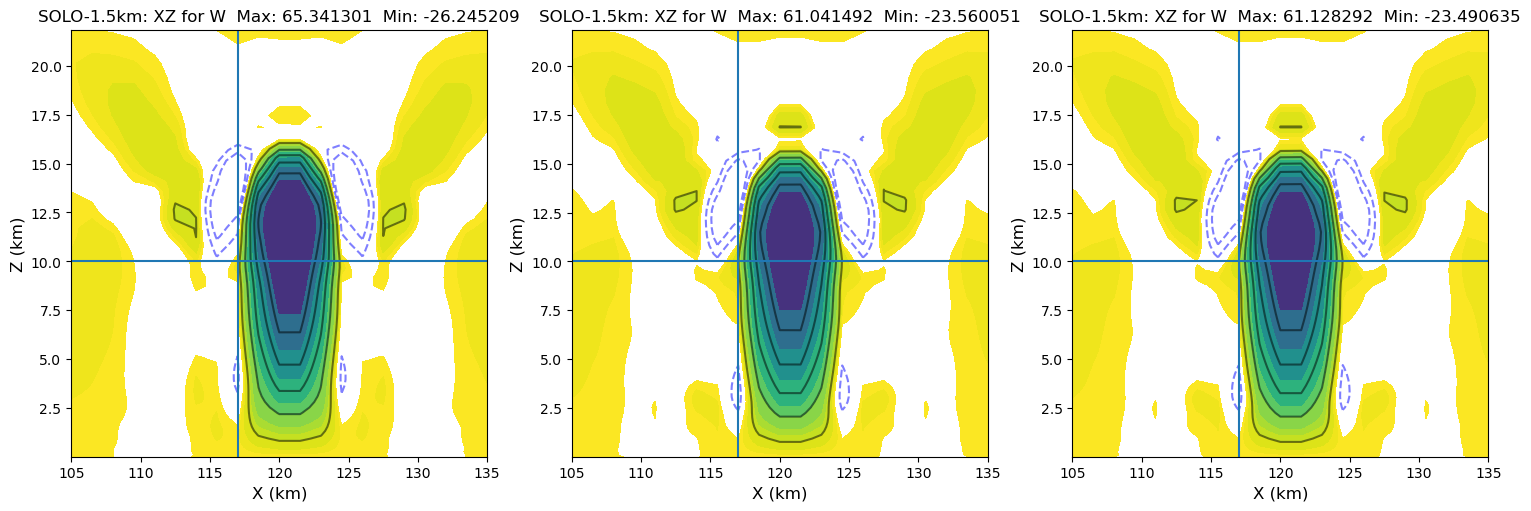

In [82]:
fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

tloc, jloc = 5, 80

x = np.tile(solo_1km[0][1]['grid_xt'], (60,1))*1.5

for n in np.arange(3):

    w_col = solo_1km[n][0]['w'][tloc,:,jloc, :]
    z_col = solo_1km[n][0]['hgt'][tloc,:,jloc, :] * 0.001

    plot_w_xz(x, z_col, w_col, ax=ax[n], title='SOLO-1.5km', range=[105,135])
    ax[n].axvline(x=117)

In [ ]:
# Plot histograms

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))
ax[0].hist(w_col, bins=10, edgecolor='black')
ax[1].hist(w_col2, bins=10, edgecolor='black')
ax[2].hist(w_col3, bins=10, edgecolor='black')
plt.show()